## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Подготовка

Импортируем необходимые библиотеки.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import copy
import warnings
warnings.filterwarnings('ignore')

Загрузим данные.

In [119]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

Посмотрим на первые 5 строк и сводную информацию датафрейма.

In [120]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Все столбцы датафрейма содержат корректные типы данных.

Ресемплируем временной ряд по одному часу, как этого требует условие задачи.

In [121]:
data = data.resample('1H').sum()

Проверим данные на пропуски.

In [122]:
data[data['num_orders'].isnull()]

,num_orders
datetime,


Временной ряд не содержит пропусков.

Данные загружены и подготовлены. Перейдем к следующему шагу - анализу данных.

# Анализ

Построим график временного ряда. Отметим на графике линии скользящего среднего и скользящего стандартного отклонения.

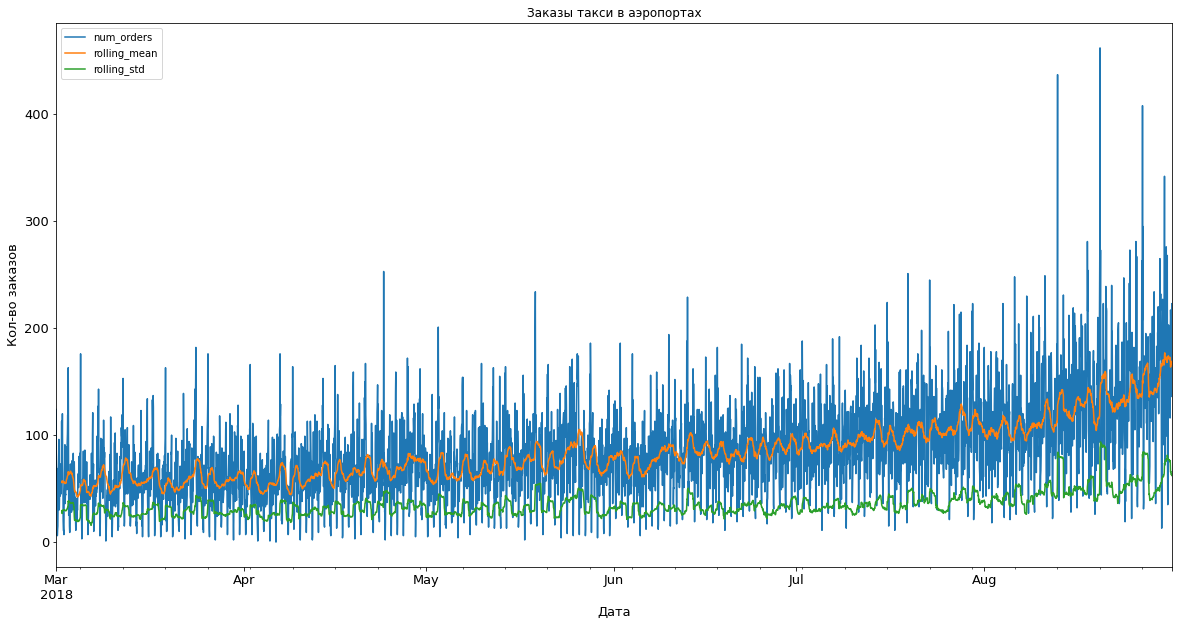

In [123]:
data['rolling_mean'] = data['num_orders'].rolling(24).mean()
data['rolling_std'] = data['num_orders'].rolling(24).std()

data.plot(figsize=(20, 10), fontsize=13)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Кол-во заказов', fontsize=13)
plt.title('Заказы такси в аэропортах');

data.drop(['rolling_mean', 'rolling_std'], axis=1, inplace=True)

Временной ряд нестационарен, т.к. со временем меняется средняя и стандартное отклонение.

Разложим временной ряд на тренд и сезонную компоненту, и построим графики сезонных составляющих.

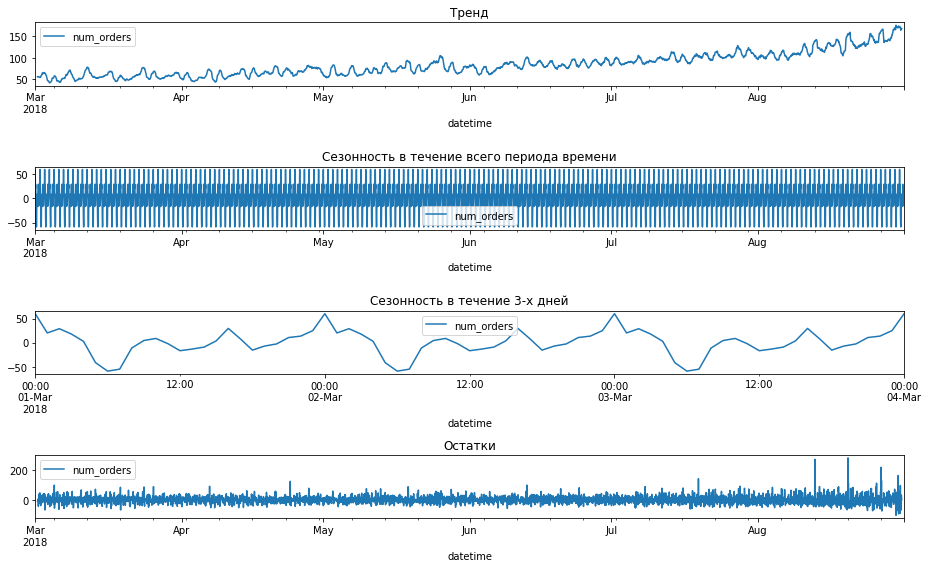

In [124]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(13, 8))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность в течение всего периода времени')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca(), xlim=(decomposed.trend.index.min(), decomposed.trend.index.min() + pd.Timedelta(days=3)))
plt.title('Сезонность в течение 3-х дней')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Тренд связан с временем года: до июня количество заказов в аэропортах примерно одинаково по всем месяцам. Но начиная с июня, данный показатель начинает медленно, но расти. Очевидно, что это связано с ростом числа путешествий, т.к. большая часть путешествий приходится на лето.

Сезонность связана с периодом меньше 1-го дня: количество заказов начинает расти с ~7-8:00 и достигает пика в полночь, а затем идет на спад.

Остатки не поддаются объяснению.

Данные проанализированы. Перейдем к следующему шагу - обучению модели.

# Обучение

Напишем функцию `make_features()`, которая добавляет следующие столбцы: 
1) четыре новых календарных признака: год, месяц, день и день недели;

2) признаки с отстающими значениями: 'lag_1', 'lag_2' — и до максимальной величины, указанной в функции;

3) признак 'rolling_mean', который отражает скользящее среднее.

Для начала сохраним копию текущей версии датафрейма.

In [125]:
data_copy = data.copy()

Создадим функция `make_features`.

In [126]:
def make_features(df, max_lag, rolling_mean_size):
    #Добавим новые столбцы
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

Для оценки качества предсказания будем изпользовать метрику RMSE. Напишем функцию `rmse_scorer`, чтобы затем передать ее в функцию `GridSearchCV`.

In [127]:
def RMSE(y_true, y_pred, **kwargs):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    return rmse

rmse_scorer = make_scorer(RMSE, greater_is_better=False)

Напишем функцию `tune_model()`, которая будет подбирать оптимальные величины `max_lag` (максимальный сдвиг) и `rolling_mean_size` (ширина окна), а затем подбирать оптимальные гиперпараметры для выбранного алгоритма с помощью `GridSearchCV`. Результатом выполнения функции будет подсчитанная метрика RMSE.

In [128]:
def best_lag_and_rolling_size(model):
    #Подбор оптимальных значений `max_lag` и `rolling_mean_size`
    best_rmse_score = 10000
    best_max_lag = 0
    best_rolling_mean_size = 0
    for max_lag in range(1, 51):
        for rolling_mean_size in range(1, 51):
            data = data_copy.copy()
            data = make_features(data, max_lag, rolling_mean_size)

            train, valid = train_test_split(data, shuffle=False, test_size=0.1)
            train = train.dropna()
            
            features_train = train.drop('num_orders', axis=1)
            target_train = train['num_orders']
            features_valid = valid.drop('num_orders', axis=1)
            target_valid = valid['num_orders']
            
            best_model = copy.deepcopy(model)
            best_model.fit(features_train, target_train)
            predictions_valid = best_model.predict(features_valid)
            rmse_score = RMSE(target_valid, predictions_valid)
            if rmse_score < best_rmse_score:
                best_rmse_score = rmse_score
                best_max_lag = max_lag
                best_rolling_mean_size = rolling_mean_size
    
    return (best_max_lag, best_rolling_mean_size)

# Тестирование

## Модель решающего дерева (`DecisionTreeRegressor`)¶

Сохраним в переменных `best_lag_decision_tree` и `best_rolling_mean_size_decision_tree` оптимальные параметры лага и размера окна скользящего среднего.

In [129]:
best_lag_decision_tree = best_lag_and_rolling_size(model=DecisionTreeRegressor(random_state=12345))[0]
best_rolling_mean_size_decision_tree = best_lag_and_rolling_size(model=DecisionTreeRegressor(random_state=12345))[1]

Найдем RMSE на тестовой выборке у модели, обученной алгоритмом решающего дерева.

In [130]:
%%time

#Подбор гиперпараметров
data = data_copy.copy()

data = make_features(data, best_lag_decision_tree, best_rolling_mean_size_decision_tree)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']   

split_index = TimeSeriesSplit().split(features_train)
model_decision_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345),
                                   param_grid={'max_depth': np.arange(1, 21), 'min_samples_leaf': [1, 5, 10, 20, 50, 100]},
                                   scoring=rmse_scorer,
                                   cv=split_index)

model_decision_tree.fit(features_train, target_train)

CPU times: user 8.85 s, sys: 11 ms, total: 8.86 s
Wall time: 8.86 s


In [131]:
predictions_decision_tree = model_decision_tree.predict(features_test)
rmse_score_decision_tree = RMSE(target_test, predictions_decision_tree)
print('Значение метрики RMSE на тестовой выборке: {:.2f}'.format(rmse_score_decision_tree))

Значение метрики RMSE на тестовой выборке: 47.63


Построим график заказов такси и их предсказаний, сделанных моделью градиентного бустинга.

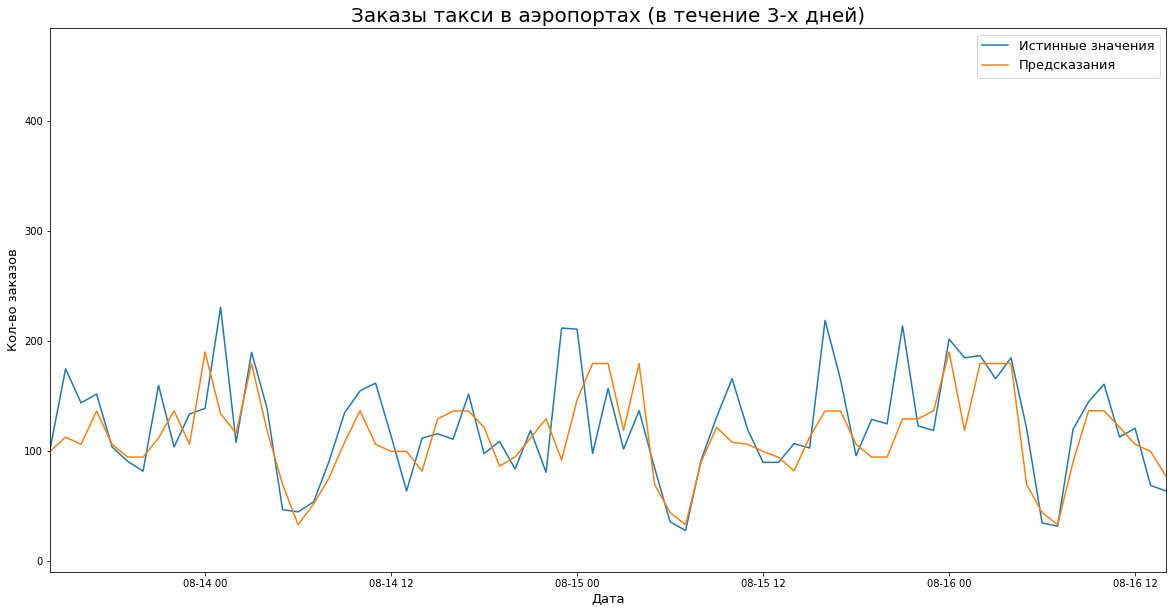

In [139]:
predictions_decision_tree = pd.DataFrame(data={'predictions_decision_tree': predictions_decision_tree},
                                         index=target_test.index)

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(target_test, label='Истинные значения')
ax.plot(predictions_decision_tree, label='Предсказания')
ax.legend(fontsize=13)

plt.xlabel('Дата', fontsize=13)
plt.ylabel('Кол-во заказов', fontsize=13)
plt.title('Заказы такси в аэропортах (в течение 3-х дней)', fontsize=20)
plt.xlim([target_test.index.min(), target_test.index.min() + pd.Timedelta(days=3)]);

Качество модели, обученной с помощью алгоритма решающего дерева, находится в пределах допустимого значения, необходимого для выполнения задачи. В следующем шаге попробуем улучшить качество модели с помощью градиентного бустинга.

## Модель градиентного бустинга (`LGBMRegressor`)¶

Сохраним в переменных `best_lag_lgbm` и `best_rolling_mean_size_lgbm` оптимальные параметры лага и размера окна скользящего среднего.

In [133]:
best_lag_lgbm = best_lag_and_rolling_size(model=DecisionTreeRegressor(random_state=12345))[0]
best_rolling_mean_size_lgbm = best_lag_and_rolling_size(model=DecisionTreeRegressor(random_state=12345))[1]

Найдем RMSE на тестовой выборке у модели, обученной алгоритмом градиентного бустинга.

In [136]:
%%time

#Подбор гиперпараметров
data = data_copy.copy()

data = make_features(data, best_lag_lgbm, best_rolling_mean_size_lgbm)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']   

split_index = TimeSeriesSplit().split(features_train)
model_lgbm = GridSearchCV(estimator=LGBMRegressor(random_state=12345),
                                   param_grid={'max_depth': np.arange(1, 21), 'n_estimators': [10, 50, 100, 150, 200]},
                                   scoring=rmse_scorer,
                                   cv=split_index)

model_lgbm.fit(features_train, target_train)
predictions_lgbm = model_lgbm.predict(features_test)
rmse_score_lgbm = RMSE(target_test, predictions_lgbm)

CPU times: user 46min 34s, sys: 6.64 s, total: 46min 41s
Wall time: 1min 10s


In [137]:
print('Значение метрики RMSE на тестовой выборке: {:.2f}'.format(rmse_score_lgbm))

Значение метрики RMSE на тестовой выборке: 44.20


Построим график заказов такси и их предсказаний, сделанных моделью градиентного бустинга.

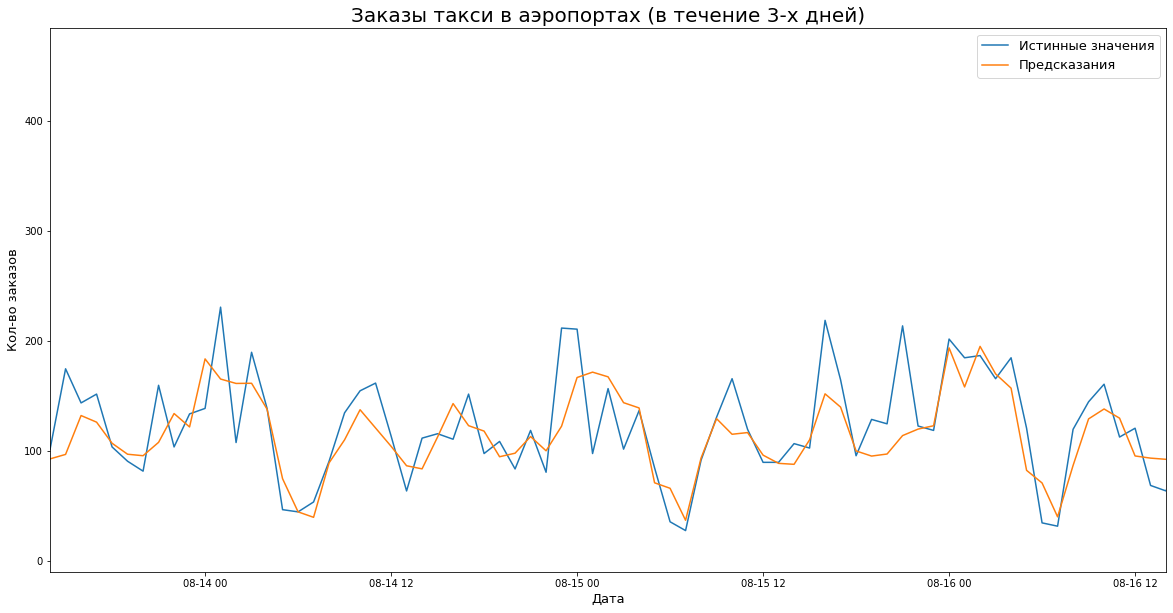

In [138]:
predictions_lgbm = pd.DataFrame(data={'predictions_lgbm': predictions_lgbm},
                                         index=target_test.index)

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(target_test, label='Истинные значения')
ax.plot(predictions_lgbm, label='Предсказания')
ax.legend(fontsize=13)

plt.xlabel('Дата', fontsize=13)
plt.ylabel('Кол-во заказов', fontsize=13)
plt.title('Заказы такси в аэропортах (в течение 3-х дней)', fontsize=20)
plt.xlim([target_test.index.min(), target_test.index.min() + pd.Timedelta(days=3)]);

# Вывод

Наилучшее качество предсказания на тестовой выборке показала модель градиентного бустинга (RMSE = 44.20), но в то же время данный алгоритм оказался самым медленным (~1 мин). В то время, как алгоритм решающего дерева уступает в качестве (RMSE = 47.63), он значительно быстрее, чем градиентный бустинг (9 секунд).